In [32]:
import pandas as pd
import ir_datasets as irds
from ir_measures import read_trec_qrels
from ir_measures import * 
from ir_measures import evaluator
import pyterrier as pt
from scipy.stats import ttest_ind
import os
from os import path as path

In [64]:
!pip install seaborn 
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 67.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.5/320.5 kB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 94.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 27.3 MB/s eta 0:00:00


# Data Ingestion

In [33]:
DIR = '../..' # if this breaks replace with a full path to the repo

DATASET = "msmarco-passage/trec-dl-2019/judged"
qrel_directory = f'{DIR}/judgments/main/qrels/'
annotation_directory = f'{DIR}/judgments/main/doccano/'

In [34]:
dataset = irds.load(DATASET)
original_qrels = pd.DataFrame(dataset.qrels_iter())

In [35]:
all_qrels = []
for file in os.listdir(qrel_directory):
    print(file)
    if file.endswith('.txt'):
        qrels = pd.DataFrame(read_trec_qrels(qrel_directory + file))
        annotator = file.replace('.txt', '').replace('-qrels', '')
        qrels['annotator'] = annotator
        all_qrels.append(qrels)

all_qrels = pd.concat(all_qrels)

saber-zerhoudi-qrels.txt
froebe-qrels.txt
harry-scells-qrels.txt
ferdinand-schlatt-qrels.txt
guglielmo-faggioli-qrels.txt
sean-macavaney-qrels.txt
andrew-parry-qrels.txt


In [36]:
all_comments = []
for file in os.listdir(annotation_directory):
    if file.endswith('.jsonl'):
        comments = pd.read_json(annotation_directory + file, lines=True)
        annotator = file.replace('.jsonl', '')
        comments['annotator'] = annotator
        # filter in case that comments 'Comments' column is an empty list
        comments = comments[comments['Comments'].apply(lambda x: len(x) > 0)]
        all_comments.append(comments)

all_comments = pd.concat(all_comments)[['text', 'annotator', 'label', 'Comments']]
all_comments['label'] = all_comments['label'].apply(lambda x: x[0])

In [37]:
RUN_DIR = f'{DIR}/runs/trec-dl-2019'
BM25_TUNED = 'dl-19-official-input.bm25tuned_p.gz'
BM25_BASE = 'dl-19-official-input.bm25base_p.gz'
SET_ENCODER_COLBERT = 'colbert_monoelectra-base_msmarco-passage-trec-dl-2019-judged.run'
COLBERT = 'maik-froebe-colbert-run.txt'
SPLADE = 'maik-froebe-splade-run.txt'
RANK_ZEPHYR = 'maik-froebe-rank-zephyr-run.txt'

In [38]:
BM25_TUNED_RUN = pt.io.read_results(path.join(RUN_DIR, BM25_TUNED)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})
BM25_BASE_RUN = pt.io.read_results(path.join(RUN_DIR, BM25_BASE)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})
SET_ENCODER_COLBERT_RUN = pt.io.read_results(path.join(RUN_DIR, SET_ENCODER_COLBERT)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})
COLBERT_RUN = pt.io.read_results(path.join(RUN_DIR, COLBERT)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})
SPLADE_RUN = pt.io.read_results(path.join(RUN_DIR, SPLADE)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})
RANK_ZEPHYR_RUN = pt.io.read_results(path.join(RUN_DIR, RANK_ZEPHYR)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})

runs = {
    'bm25_tuned': BM25_TUNED_RUN,
    'bm25_base': BM25_BASE_RUN,
    'set_encoder_colbert': SET_ENCODER_COLBERT_RUN,
    'colbert': COLBERT_RUN,
    'splade': SPLADE_RUN,
    'rank_zephyr': RANK_ZEPHYR_RUN
}

# Effectiveness

In [39]:
metrics = [AP(rel=2), NDCG(cutoff=10), R(rel=2)@100, P(rel=2, cutoff=10), RR(rel=2), RR(rel=2, cutoff=10)]

In [40]:
original_evaluator = evaluator(metrics, qrels=original_qrels)

In [41]:
def convert_qrels(qrels, shuffle_grades=False):
    # sort qrels by query_id and then by relevance
    qrels = qrels.sort_values(by=['query_id', 'relevance'], ascending=[True, False])
    if shuffle_grades:
        # re-order randomly within each relevance group for a query
        qrels['relevance'] = qrels.groupby(['query_id', 'relevance'])
    # give a score = to the inverse rank
    qrels['score'] = qrels.groupby('query_id').cumcount(ascending=False) + 1
    return qrels

In [56]:
annotator_out = []
for annotator, qrels in all_qrels.groupby('annotator'):
    annotator_evaluator = evaluator(metrics, qrels=qrels)
    relevant_queries = qrels['query_id'].unique()
    query_set = list(relevant_queries)
    rez = convert_qrels(qrels)
    measures = original_evaluator.calc_aggregate(rez)
    measures = {str(k): v for k, v in measures.items()}
    measures['annotator'] = annotator
    measures['run'] = 'annotator'
    measures['type'] = 'official'
    measures['queries'] = query_set
    annotator_out.append(measures)

    for run_name, run in runs.items():
        run = run[run['query_id'].isin(relevant_queries)]
        run_measures = original_evaluator.calc_aggregate(run)
        run_measures = {str(k): v for k, v in run_measures.items()}
        run_measures['annotator'] = annotator
        run_measures['run'] = run_name
        run_measures['type'] = 'official'
        run_measures['queries'] = query_set
        annotator_out.append(run_measures)

        run_measures = annotator_evaluator.calc_aggregate(run)
        run_measures = {str(k): v for k, v in run_measures.items()}
        run_measures['annotator'] = annotator
        run_measures['run'] = run_name
        run_measures['type'] = 'annotator'
        run_measures['queries'] = query_set
        annotator_out.append(run_measures)


annotator_out = pd.DataFrame(annotator_out)

In [57]:
annotator_out

,RR(rel=2),P(rel=2)@10,R(rel=2)@100,nDCG@10,RR(rel=2)@10,AP(rel=2),annotator,run,type,queries
0,0.232558,0.174419,0.252918,0.213256,0.232558,0.188970,andrew-parry,annotator,official,"[855410, 146187, 130510, 1110199, 490595, 5737..."
1,0.268217,0.139535,0.165347,0.173879,0.268217,0.118552,andrew-parry,bm25_tuned,official,"[855410, 146187, 130510, 1110199, 490595, 5737..."
2,0.477137,0.223077,0.535538,0.344164,0.473932,0.242412,andrew-parry,bm25_tuned,annotator,"[855410, 146187, 130510, 1110199, 490595, 5737..."
3,0.266279,0.139535,0.162255,0.175449,0.266279,0.117299,andrew-parry,bm25_base,official,"[855410, 146187, 130510, 1110199, 490595, 5737..."
4,0.458275,0.269231,0.549753,0.374594,0.451282,0.254570,andrew-parry,bm25_base,annotator,"[855410, 146187, 130510, 1110199, 490595, 5737..."
...,...,...,...,...,...,...,...,...,...,...
86,0.626094,0.306667,0.574544,0.513298,0.624074,0.311839,sean-macavaney,colbert,annotator,"[405717, 182539, 131843, 1113437, 443396, 1117..."
87,0.290698,0.158140,0.181022,0.219697,0.290698,0.120823,sean-macavaney,splade,official,"[405717, 182539, 131843, 1113437, 443396, 1117..."
88,0.669444,0.333333,0.606484,0.539445,0.666667,0.331608,sean-macavaney,splade,annotator,"[405717, 182539, 131843, 1113437, 443396, 1117..."
89,0.252713,0.172093,0.161547,0.218379,0.252713,0.110299,sean-macavaney,rank_zephyr,official,"[405717, 182539, 131843, 1113437, 443396, 1117..."


In [61]:
annotator_out['query_tuple'] = annotator_out['queries'].apply(tuple)
unique_queries = {tuple_queries: idx for idx, tuple_queries in enumerate(annotator_out['query_tuple'].unique())}
annotator_out['query_idx'] = annotator_out['query_tuple'].apply(lambda x: unique_queries[x])

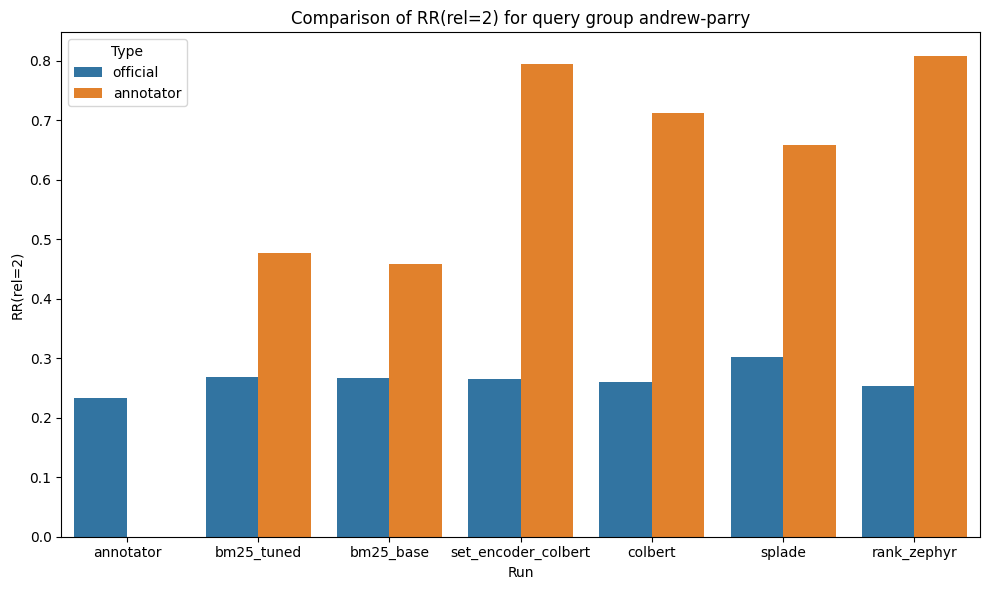

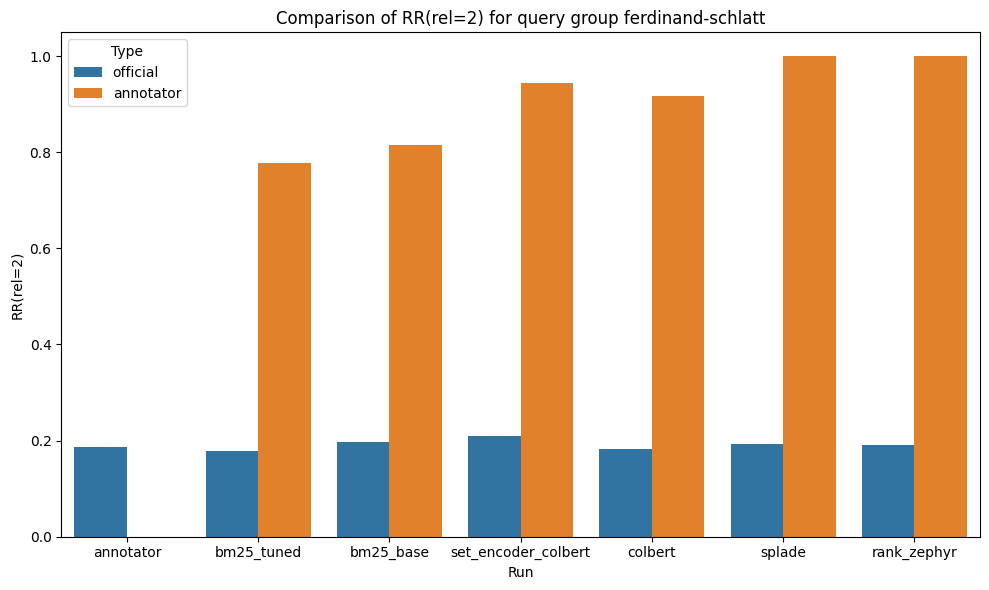

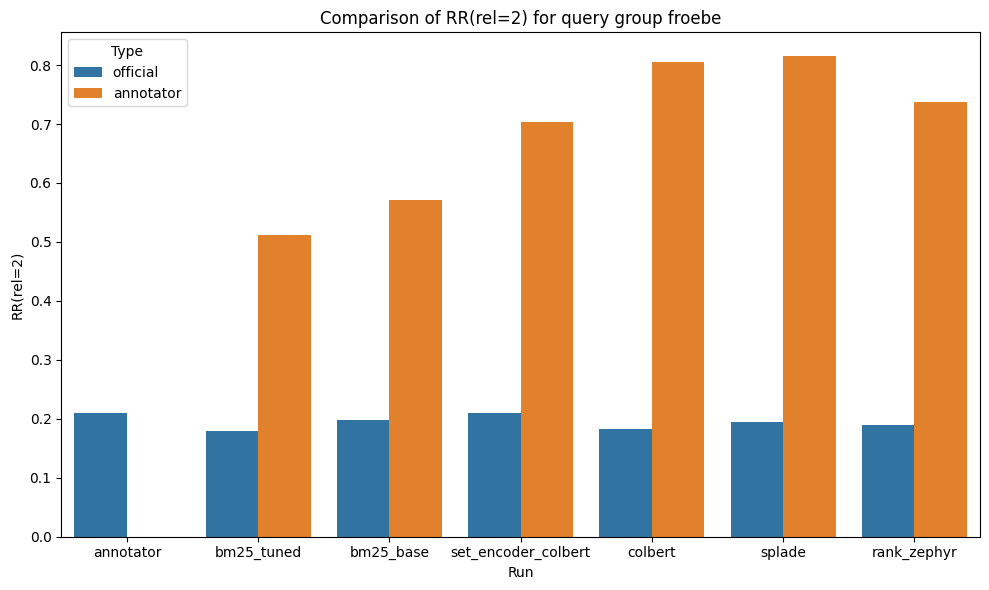

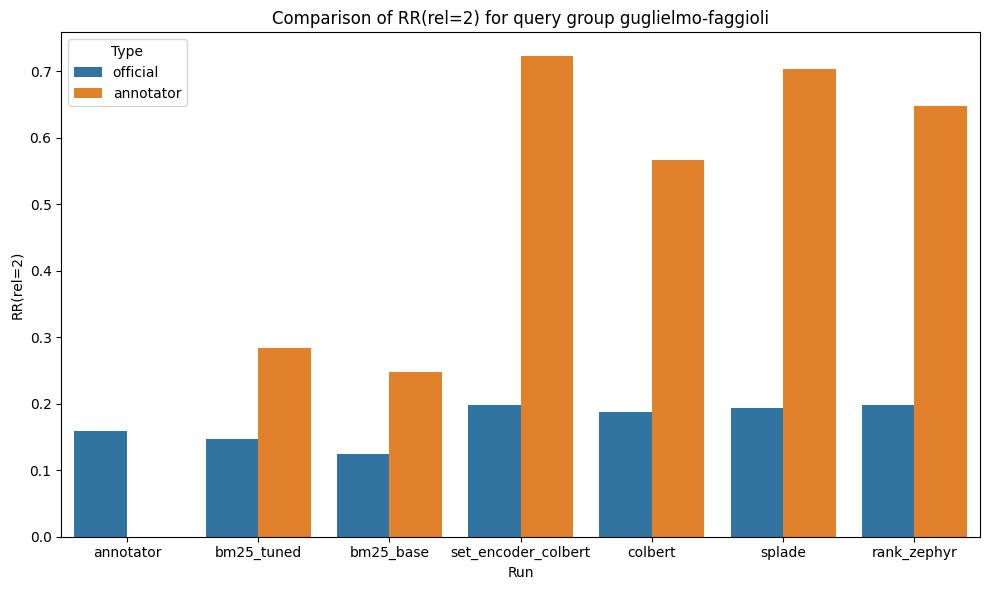

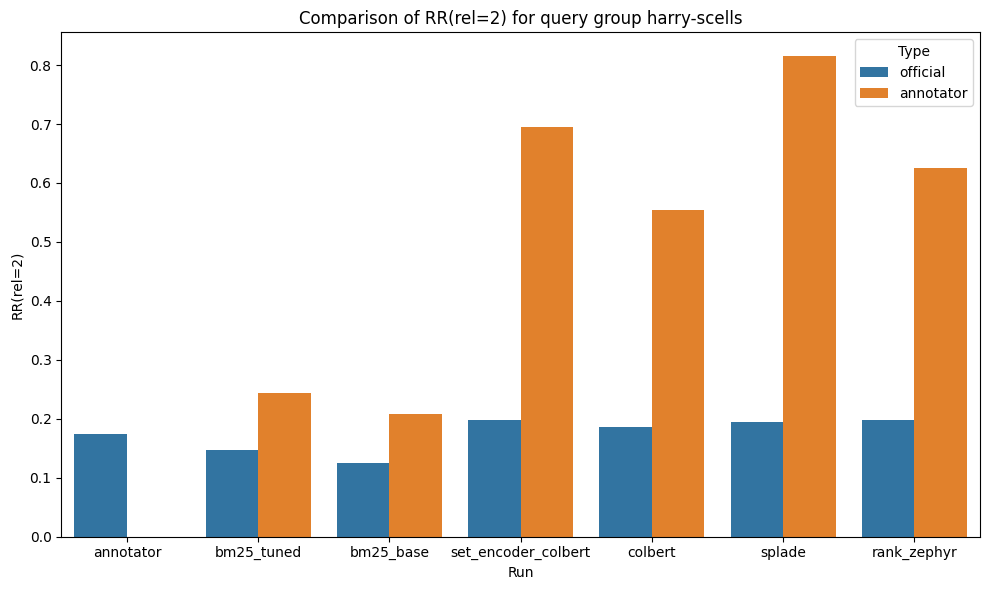

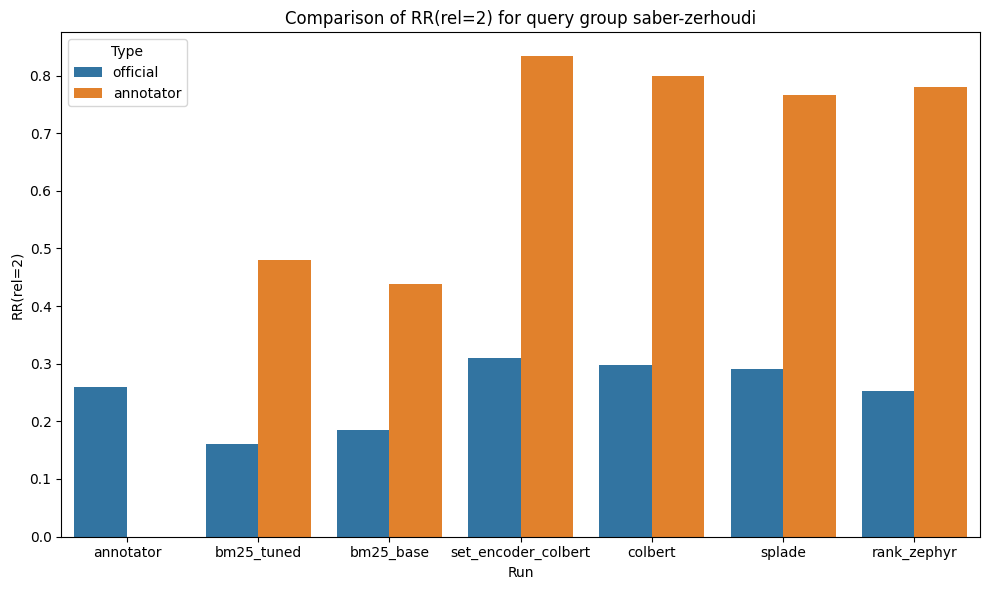

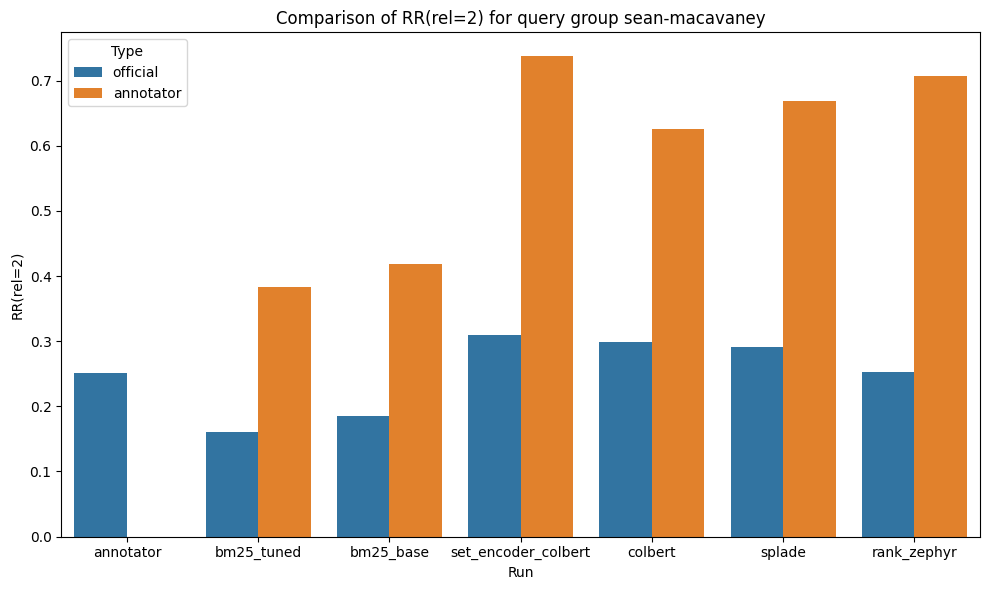

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metric_by_type(df, metric):
    unique_groups = df['annotator'].unique()
    
    # Create a plot for each unique group of queries
    for group in unique_groups:
        subset = df[df['annotator'] == group]
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='run', y=metric, hue='type', data=subset)
        
        plt.title(f'Comparison of {metric} for query group {group}')
        plt.ylabel(metric)
        plt.xlabel('Run')
        plt.legend(title='Type')
        plt.tight_layout()
        plt.show()

# Example: Plot 'RR(rel=2)'
plot_metric_by_type(annotator_out, 'RR(rel=2)')

## Oracles

In [69]:
max_qrels = all_qrels.groupby(['query_id', 'doc_id']).agg({'relevance': 'max'}).reset_index()
min_qrels = all_qrels.groupby(['query_id', 'doc_id']).agg({'relevance': 'min'}).reset_index()

In [72]:
max_run = convert_qrels(max_qrels)
min_run = convert_qrels(min_qrels)

In [73]:
print(original_evaluator.calc_aggregate(max_run))
print(original_evaluator.calc_aggregate(min_run))

{RR(rel=2): 0.8273703041144902, P(rel=2)@10: 0.7069767441860466, R(rel=2)@100: 0.8904596258690991, nDCG@10: 0.7900298933515477, RR(rel=2)@10: 0.8255813953488372, AP(rel=2): 0.7069868047594504}
{RR(rel=2): 0.8505813953488373, P(rel=2)@10: 0.6930232558139536, R(rel=2)@100: 0.881568897209882, nDCG@10: 0.7925250135090118, RR(rel=2)@10: 0.8505813953488373, AP(rel=2): 0.6841686009853162}
